# Traffic Accidents in Toronto 

## Exploring the Killed or Seriously Injured (KSI) Data from 2006 to 2020

The following project is an attempt of exploring the data availabe and put forth by the Toronto Police Service in regards to traffic accidents resulting in a casualty or serious injuries (the ones requiring hopistal admission). The data spans from 2006 to 2020.

As well as exploring dimensions such as yearly distribution, neighbourhood distribution and demographic aspects of a KSI-type accident, I want to assess whether the causes for accidents, the parties involved in it, and the road and light/visiblity conditions are good dimensions to discern whether an accident is fatal or not.

Data was collected from the Toronto Police Service's [Public Safety Data Portal](https://data.torontopolice.on.ca/datasets/ksi/explore).


In [59]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import datetime as date
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV


import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

The way incidents and features are reported, it lends to lots of Null values (which might indicate abscence of the observable feature).

* 'Null' values where processed on Sheets by replacing them in categorical variables with 'No Record.' 

* Dimensions related to the parties involved in accidents were codified with 1s (for 'True' values) and 0s (for 'Null' values). 'True' and 'Null' implies existence or lack of thereof, but records for parties involved are not aggregated. Accidents with multiple parties involved had more than one row input, there affecting all dimensions involved. Hence the amount of missing data. It can due to an absence of injury, or that the information was not recorded.

* Thus, a single accident has different counts for dimensions such as age, type of injure, fatality, party involved and even vehicle.

* Initial EDA was showing double bleeps and offering a skewed representation of the data.

* Dropping duplicates is not a possibility, as valuble information might be lost. 

* A different approach was needed, one that required reducing the amount of dimensions of interest, focusing on those who have the most complete data.


In [60]:
#reverted to a method to see how many 'No Record'/NaN markers are in the whole dataset
df = pd.read_csv(r"C:\Users\migue\Downloads\KSI.csv")
df_nulls = df.replace('No record', np.nan) 

#count of values considered as null
null_count = df_nulls.isna().sum()

#frequency of nulls for each dimension
null_freq = null_count / len(df_nulls) * 100
null_freq

X                   0.000000
Y                   0.000000
INDEX_              0.000000
ACCNUM              0.000000
YEAR                0.000000
DATE                0.000000
TIME                0.000000
HOUR                0.000000
STREET1             0.000000
STREET2             8.956109
STREET              0.000000
OFFSET             83.712930
ROAD_CLASS          2.947805
DISTRICT            0.836299
WARDNUM             1.162515
DIVISION            1.162515
LATITUDE            0.000000
LONGITUDE           0.000000
LOCCOORD            0.622776
ACCLOC             32.325030
TRAFFCTL            0.172005
VISIBILITY          0.106762
LIGHT               0.000000
RDSFCOND            0.136418
ACCLASS             0.000000
IMPACTYPE           0.023725
INVTYPE             0.071174
INVAGE              0.000000
INJURY              9.561091
FATAL_NO           95.771056
INITDIR            29.027284
VEHTYPE            16.684460
MANOEUVER          42.900356
DRIVACT            49.810202
DRIVCOND      

The above calculation renders the following dimensions:

In [61]:
#there are 58 dimensions, and many of them show a high number or nan/no record values
df_nulls.shape

(16860, 58)

With so many columns displaying high percentages of unreported values, I downsized the shape the dataset.

In [62]:
#dropping the columns with a high volume of nan/no record, plus Street, which was concatenated on Sheets, but of little value
df_nulls.drop(columns = ['STREET', 'OFFSET', 'FATAL_NO', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT','CYCCOND'], inplace = True)

In [63]:
#downsizing the df to 49 columns
df_nulls.shape

(16860, 49)

Accidents reported are recoded more than once, depending on the parties involved. Such multiciplity of entries might result in issues when aggregating and visualizing data, so it helps to bear in mind the amount of unique accident numbers present in the data set. As stated above, duplicity control is of the utmost importance has to be checked at every stage of the exploratory process.

In [64]:
df_nulls['ACCNUM'].nunique()

6002

Initially, 'ACCLASS' column is almost binary in how it's reported, and 'Property Damage Only', by definition, is non-fatal, so it can be grouped.
It will be of help when correlating 'ACCLASS' against other variables.

In [65]:
#passing condition so the two counts of Property Damage Only are part of the Non-Fatal count
#where method helps in adding the two values to non-fatal group, counting as non-fatal, what its labeled as damage to property
df_nulls['ACCLASS'] = np.where(df['ACCLASS'] == 'Property Damage Only', 'Non-Fatal Injury', df_nulls['ACCLASS'])

In [66]:
df_nulls['ACCLASS'].value_counts()

Non-Fatal Injury    14563
Fatal                2297
Name: ACCLASS, dtype: int64

Most of the dimensions in this dataset are categorial, so at this point, turning them into categories will be of help mpving forward, especially when enconding them for regression/classifications analyses.

In [67]:
#changing object type columns into categorical data, to reflect the way they are input in the dataset
for col in df_nulls.select_dtypes(['object']):
    df_nulls[col] = df_nulls[col].astype('category')

In [68]:
df_nulls.dtypes

X                   float64
Y                   float64
INDEX_                int64
ACCNUM                int64
YEAR                  int64
DATE               category
TIME                  int64
HOUR                  int64
STREET1            category
STREET2            category
ROAD_CLASS         category
DISTRICT           category
WARDNUM            category
DIVISION           category
LATITUDE            float64
LONGITUDE           float64
LOCCOORD           category
ACCLOC             category
TRAFFCTL           category
VISIBILITY         category
LIGHT              category
RDSFCOND           category
ACCLASS            category
IMPACTYPE          category
INVTYPE            category
INVAGE             category
INJURY             category
INITDIR            category
VEHTYPE            category
MANOEUVER          category
DRIVACT            category
DRIVCOND           category
PEDESTRIAN            int64
CYCLIST               int64
AUTOMOBILE            int64
MOTORCYCLE          

'Date' was converted in the bath. Let's reverse that and create ad-hoc columns for features such as month or day of the week, which will help in retrieving more inisght about when accidents took place on an aggregate scale.

In [69]:
#convert into date time, same for hour and time
df_nulls['DATE'] = pd.to_datetime(df_nulls['DATE'])

In [70]:
df_nulls['ACCNUM'].duplicated()

0        False
1         True
2        False
3         True
4        False
         ...  
16855     True
16856    False
16857     True
16858     True
16859     True
Name: ACCNUM, Length: 16860, dtype: bool

In [71]:
#at this point, it helps to have the month and week extracted out of Date
df_nulls['MONTH'] = pd.DatetimeIndex(df_nulls['DATE']).month
df_nulls['DAY OF WEEK'] = df_nulls['DATE'].dt.weekday
df_nulls.head()
df_nulls.describe()

,X,Y,INDEX_,ACCNUM,YEAR,TIME,HOUR,LATITUDE,LONGITUDE,PEDESTRIAN,...,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_ID,ObjectId,MONTH,DAY OF WEEK
count,1.686000e+04,1.686000e+04,1.686000e+04,1.686000e+04,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,...,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000
mean,-8.838272e+06,5.420819e+06,3.475220e+07,2.263460e+09,2012.256168,1352.106821,13.241103,43.710920,-79.395546,0.404923,...,0.377343,0.135528,0.516192,0.083571,0.043832,0.027758,74.003618,8430.500000,6.802610,3.003796
std,1.159490e+04,8.664361e+03,3.657126e+07,3.263836e+09,4.252797,629.726747,6.302679,0.056254,0.104159,0.490892,...,0.484736,0.342297,0.499753,0.276751,0.204726,0.164284,41.411541,4867.207105,3.288337,1.971048
min,-8.865305e+06,5.402256e+06,3.363207e+06,2.530100e+04,2006.000000,0.000000,0.000000,43.590289,-79.638390,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,-8.846402e+06,5.413345e+06,5.358714e+06,1.065135e+06,2009.000000,913.000000,9.000000,43.662398,-79.468578,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,4215.750000,4.000000,1.000000
50%,-8.838358e+06,5.419639e+06,7.474276e+06,1.293196e+06,2012.000000,1442.000000,14.000000,43.703284,-79.396323,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,77.000000,8430.500000,7.000000,3.000000
75%,-8.829527e+06,5.427906e+06,8.063194e+07,5.001806e+09,2016.000000,1845.000000,18.000000,43.756945,-79.316990,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,112.000000,12645.250000,10.000000,5.000000
max,-8.808254e+06,5.443099e+06,8.154201e+07,9.085345e+09,2020.000000,2359.000000,23.000000,43.855445,-79.125896,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,140.000000,16860.000000,12.000000,6.000000


# EDA

Let's start by getting a top-view visual of the KSI incidents in Toronto. Police keeps records of multiple dimensiones of a traffic accident that results in a death or produces serious injuries. 

The [metadata](https://data.torontopolice.on.ca/datasets/ksi-metadata/explore) can be found at the Public Safety Data Portal.

However, for the purposes of this section, these are some of the definitions of the dimensions used:

*  VISIBILITY	Environment Condition
* LIGHT	Light Condition
* INVTYPE	Involvement Type 
* INVAGE	Age of Involved Party
* PEDESTRIAN	Pedestrian Involved In Collision
* CYCLIST	Cyclists Involved in Collision
* AUTOMOBILE	Driver  Involved in Collision
* MOTORCYCLE	Motorcyclist  Involved in Collision
* TRUCK	Truck Driver  Involved in Collision
* TRSN_CITY_VEH	Transit or City Vehicle  Involved in Collision
* EMERG_VEH	Emergency Vehicle  Involved in Collision
* PASSENGER	Passenger Involved in Collision
* SPEEDING	Speeding Related Collision
* AG_DRIV	Aggressive and Distracted Driving Collision
* REDLIGHT	Red Light Related Collision
* ALCOHOL	Alcohol Related Collision
* DISABILITY	Medical or Physical Disability Related Collision


It helps to get an idea of the general trend in accidents to see the yearly evolution of accidents reported. While results only span to 2020, there seems to be downward trend, in general terms.

In [72]:
#check accidents per year 
yearly_ksi_instances = df_nulls.groupby('YEAR')['ACCNUM'].nunique()
yearly_ksi_instances

YEAR
2006    481
2007    453
2008    417
2009    438
2010    400
2011    399
2012    453
2013    431
2014    350
2015    350
2016    386
2017    392
2018    422
2019    365
2020    265
Name: ACCNUM, dtype: int64

<AxesSubplot:xlabel='YEAR'>

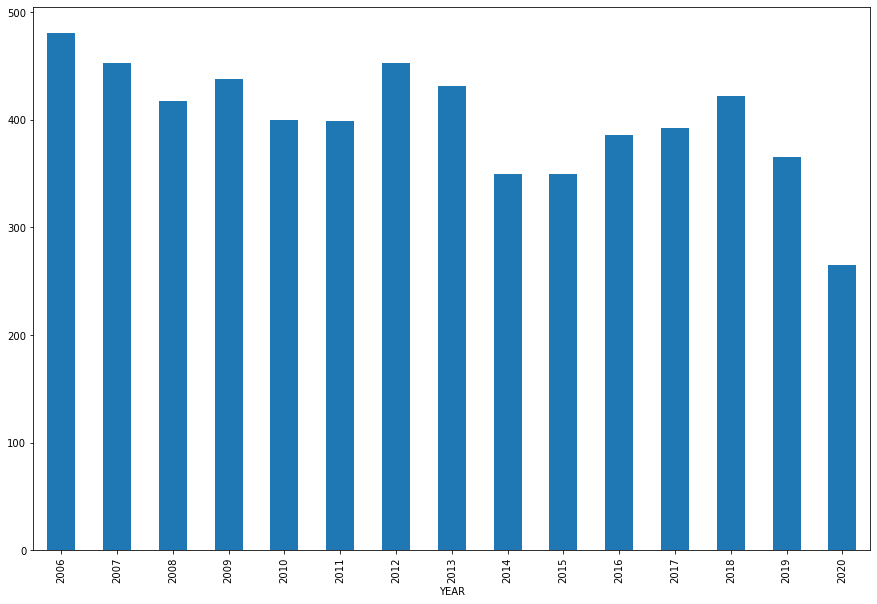

In [73]:
yearly_ksi_instances.plot(kind = 'bar', figsize=(15, 10))

If those are to the total numbers per year, what is the distribution per district? Toronto Police has records for the following districts, revealing that Toronto and East York is the district with the highest count of reports:

In [74]:
#first, regroup the labels with similar wording, like I did with fatal and non-fatal accidents, as there was a Toronto East York label
df_nulls['DISTRICT'] = np.where(df['DISTRICT'] == 'Toronto East York', 'Toronto and East York', df_nulls['DISTRICT'])
df_nulls.groupby('DISTRICT')['ACCNUM'].nunique()

DISTRICT
Etobicoke York           1373
North York               1185
Scarborough              1317
Toronto and East York    2065
Name: ACCNUM, dtype: int64

That's the account for districts, but which are the neighbourhood with the highets count of accidents? Let's take a look at the the top-20:

(<AxesSubplot:xlabel='NEIGHBOURHOOD'>,
 NEIGHBOURHOOD
 Waterfront Communities-The Island (77)      222
 West Humber-Clairville (1)                  170
 Bay Street Corridor (76)                    141
 Rouge (131)                                 132
 Woburn (137)                                120
 South Riverdale (70)                        118
 Wexford/Maryvale (119)                      117
 Islington-City Centre West (14)             102
 Moss Park (73)                               98
 Church-Yonge Corridor (75)                   96
 Downsview-Roding-CFB (26)                    94
 South Parkdale (85)                          88
 Clairlea-Birchmount (120)                    87
 York University Heights (27)                 84
 Kensington-Chinatown (78)                    83
 Dovercourt-Wallace Emerson-Junction (93)     81
 Annex (95)                                   79
 Mimico (17)                                  79
 Milliken (130)                               75
 Malvern (132) 

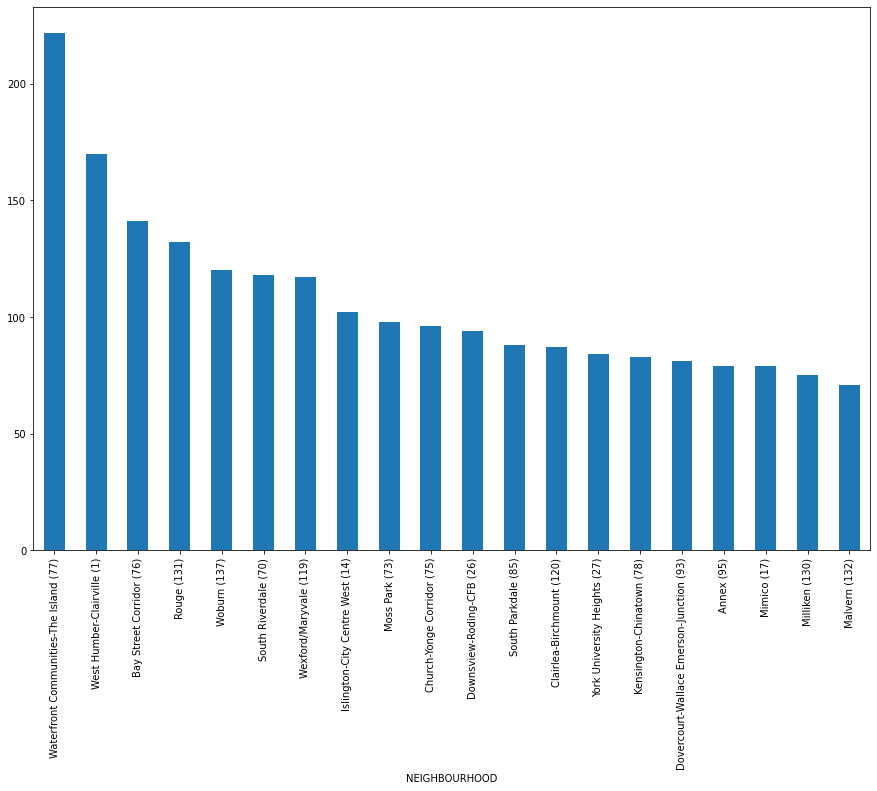

In [75]:
#accidents per neighborhood, counting top-20
ksi_neighbourhood_top = df_nulls.groupby('NEIGHBOURHOOD')['ACCNUM'].nunique().nlargest(20)
(ksi_neighbourhood_top.plot(kind='bar', figsize=(15, 10)), ksi_neighbourhood_top)

These are the neighbourhood that have logged the lowest number of accidents over 14 years. While it overreaches the scope of the analysis and this data, it would be of interest to learn about the population density and road makeup of these neighbourhoods.

(<AxesSubplot:xlabel='NEIGHBOURHOOD'>,
 NEIGHBOURHOOD
 Lambton Baby Point (114)          4
 Maple Leaf (29)                   7
 Guildwood (140)                  10
 Lawrence Park North (105)        10
 Playter Estates-Danforth (67)    10
 Humewood-Cedarvale (106)         11
 North St.James Town (74)         12
 Caledonia-Fairbank (109)         13
 Highland Creek (134)             13
 Pleasant View (46)               14
 Taylor-Massey (61)               14
 Danforth (66)                    15
 Elms-Old Rexdale (5)             15
 Ionview (125)                    15
 Westminster-Branson (35)         15
 Yonge-St.Clair (97)              15
 Markland Wood (12)               16
 Woodbine-Lumsden (60)            16
 Bayview Woods-Steeles (49)       17
 Blake-Jones (69)                 17
 Name: ACCNUM, dtype: int64)

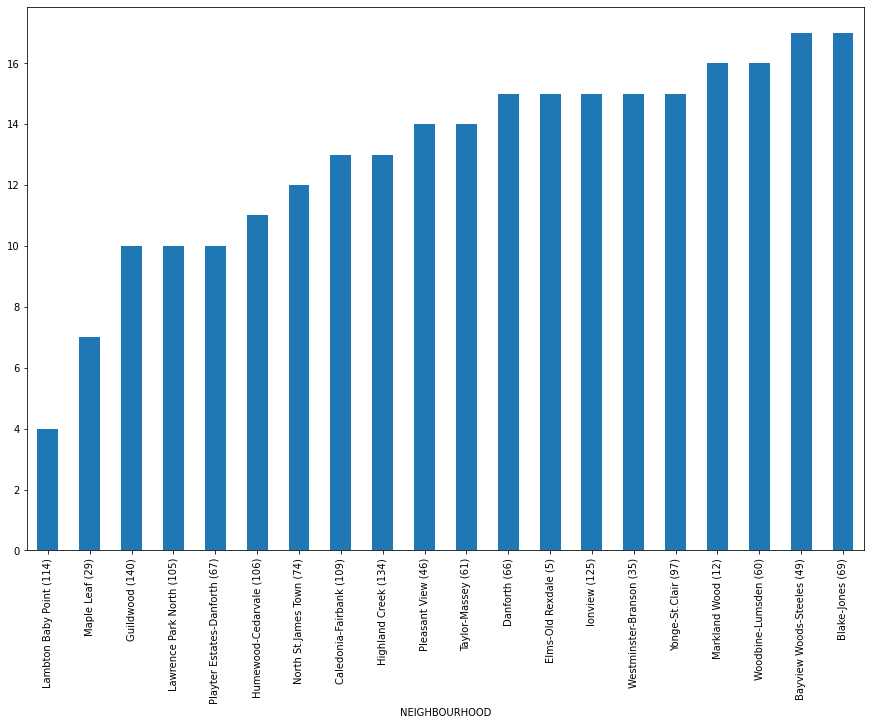

In [76]:
bottom_20 = df_nulls.groupby('NEIGHBOURHOOD')['ACCNUM'].nunique().nsmallest(20)
bottom_20.plot(kind='bar', figsize=(15, 10)), bottom_20

Moving on to the main dimension of the dataset, we will now take a look at the distriburion of fatal and non-fatal accidents. It should be noted that fatal are the injuries where death occurs in less than 366 days as result of the collision. “Fatal” does not include death from natural causes (heart attack, stroke, epilated seizure, etc.) or suicide.

In [77]:
#How many fatal accidents have taken place per year?
accident_type = df_nulls.groupby('YEAR')['ACCLASS'].value_counts()
accident_type

YEAR  ACCLASS         
2006  Non-Fatal Injury    1294
      Fatal                189
2007  Non-Fatal Injury    1305
      Fatal                169
2008  Non-Fatal Injury    1060
      Fatal                179
2009  Non-Fatal Injury    1109
      Fatal                133
2010  Non-Fatal Injury    1033
      Fatal                157
2011  Non-Fatal Injury    1056
      Fatal                123
2012  Non-Fatal Injury    1223
      Fatal                125
2013  Non-Fatal Injury    1020
      Fatal                212
2014  Non-Fatal Injury     782
      Fatal                134
2015  Non-Fatal Injury     772
      Fatal                157
2016  Non-Fatal Injury     818
      Fatal                188
2017  Non-Fatal Injury     836
      Fatal                144
2018  Non-Fatal Injury     923
      Fatal                151
2019  Non-Fatal Injury     788
      Fatal                147
2020  Non-Fatal Injury     544
      Fatal                 89
Name: ACCLASS, dtype: int64

Zooming on the type of injury, there are 5 types of injuries a person involved in an accident can sustain fatal injuries are the least to occur, but major injuries occur at a worrisome rate. It should be noted that a major injury is a non-fatal injury that is severe enough to require the injured person to be admitted to hospital, even if only for observation at the time of the collision. Examples of that are fractures, internal injuries, severe cuts, crushing, burns, concussions, or severe general shocks. It should also be noted that one accident might have multiple outcomes. 

In [78]:
injuries = df_nulls['INJURY'].value_counts() #relative frequencies of the injury types
injuries

None       6406
Major      5668
Minor      1311
Minimal    1042
Fatal       821
Name: INJURY, dtype: int64

<AxesSubplot:>

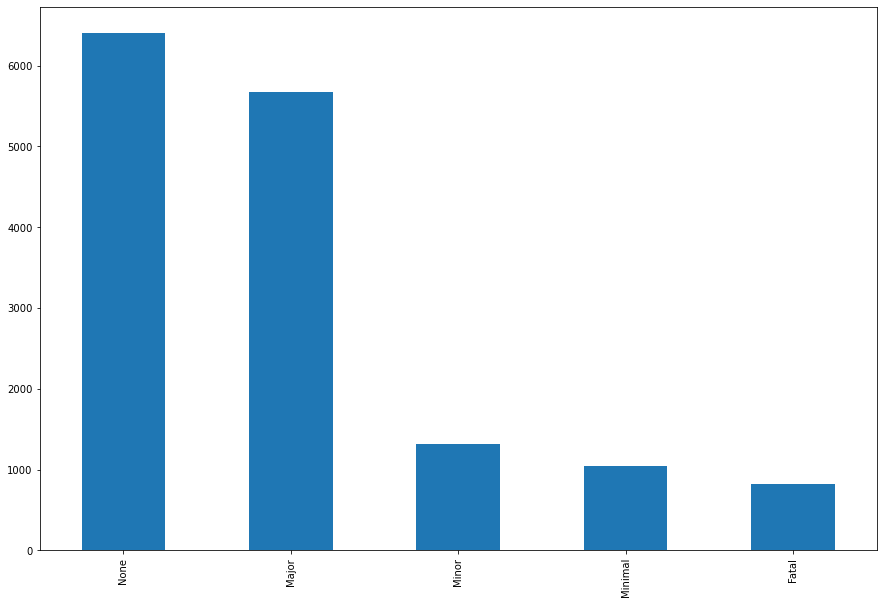

In [79]:
injuries.plot(kind='bar', figsize=(15, 10))

Let's take a look now a what groups have recorded more incidents. Not surprsingly, drivers, pedestrians and passengers are sitting atop of the list.

In [80]:
df_nulls['INVTYPE'].value_counts()

Driver                  7618
Pedestrian              2871
Passenger               2543
Vehicle Owner           1636
Cyclist                  726
Motorcycle Driver        607
Truck Driver             316
Other Property Owner     257
Other                    174
Motorcycle Passenger      32
Moped Driver              27
Driver - Not Hit          17
Wheelchair                13
In-Line Skater             5
Cyclist Passenger          2
Trailer Owner              2
Pedestrian - Not Hit       1
Witness                    1
Name: INVTYPE, dtype: int64

## SEASONALITY, WEEKLY AND HOURLY FREQUENCY OF ACCIDENTS

Let's check which are the months with the highest accident frequency.

Overall, is during Summer and Early Fall when the most accidents take place. 

<AxesSubplot:xlabel='MONTH'>

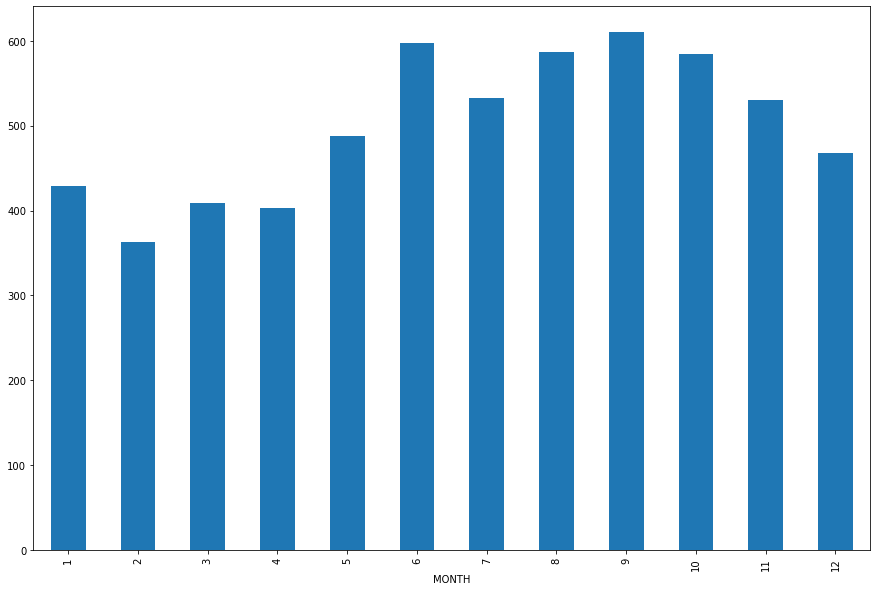

In [81]:
ksi_month = df_nulls.groupby('MONTH')['ACCNUM'].nunique()
ksi_month.plot(kind = 'bar', figsize=(15, 10))

Looking at the distribution of accidents per day of the week, Friday is the day with most accidents reported.

(<AxesSubplot:xlabel='DAY OF WEEK'>,
 DAY OF WEEK
 0    819
 1    895
 2    889
 3    875
 4    952
 5    804
 6    768
 Name: ACCNUM, dtype: int64)

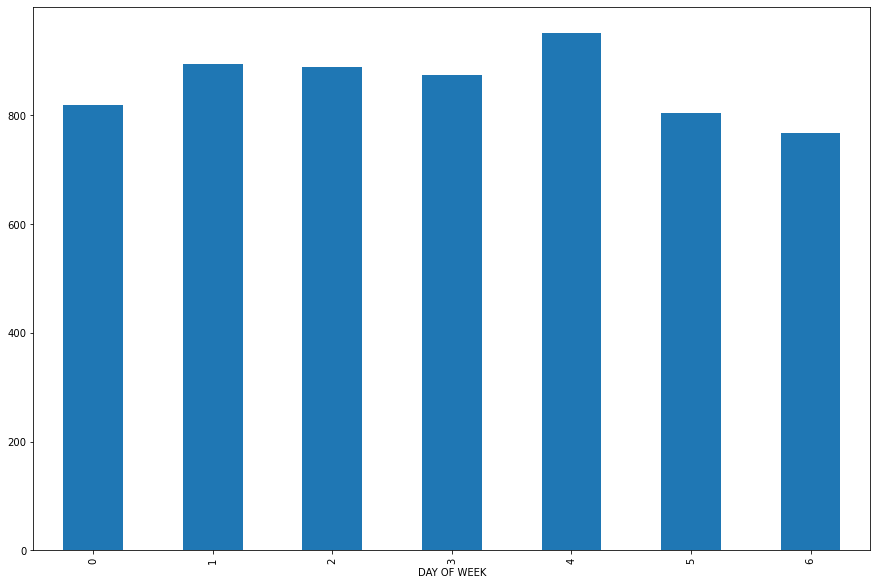

In [82]:
ksi_day = df_nulls.groupby('DAY OF WEEK')['ACCNUM'].nunique()
ksi_day.plot(kind = 'bar', figsize=(15, 10)), ksi_day

What the following chart and plot tells us is that the evening holds the highest number of accident, especially the cluster of hours between 3PM and 7PM, hours of gigh density of traffic, as people are commuting home.

(<AxesSubplot:xlabel='HOUR'>,
 HOUR
 0     173
 1     144
 2     162
 3     134
 4      61
 5     104
 6     203
 7     210
 8     242
 9     264
 10    259
 11    253
 12    265
 13    282
 14    325
 15    358
 16    340
 17    392
 18    424
 19    345
 20    317
 21    302
 22    244
 23    199
 Name: ACCNUM, dtype: int64)

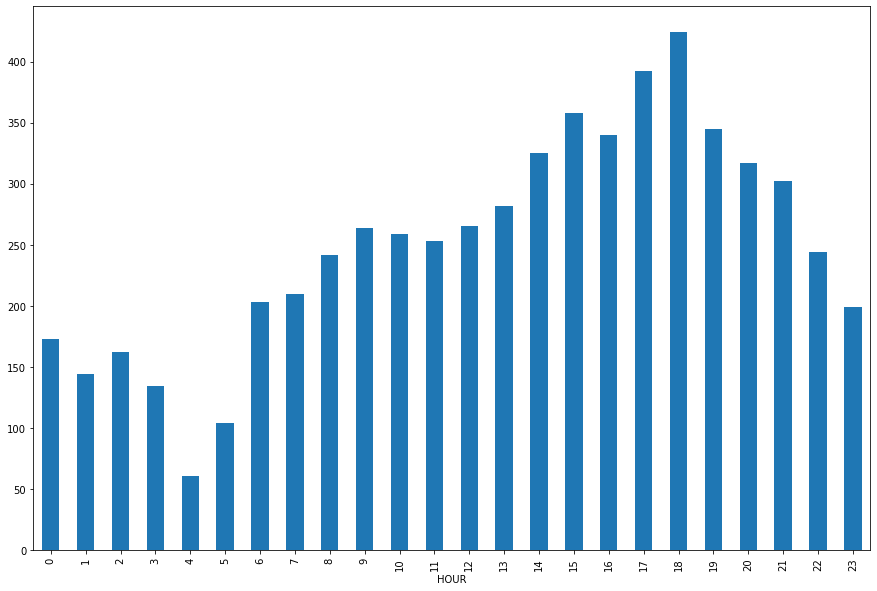

In [83]:
ksi_hour = df_nulls.groupby('HOUR')['ACCNUM'].nunique()
(ksi_hour.plot(kind = 'bar', figsize=(15, 10)), ksi_hour)

# Distribution of Accident Causes

The following chart and plot were created to offer an overview of the accidentS, both yearly and by district. Aggresive driving has consistently be the main reason behind many episodes of fatal or near-fatal traffic accidents.

In [84]:
causes = pd.pivot_table(index = 'YEAR', data = df_nulls, values = ['ALCOHOL', 'AG_DRIV', 'DISABILITY', 'REDLIGHT', 'SPEEDING'], aggfunc = np.sum)
causes

,AG_DRIV,ALCOHOL,DISABILITY,REDLIGHT,SPEEDING
YEAR,,,,,
2006,715,95,47,136,227
2007,771,85,31,190,224
2008,627,77,67,122,168
2009,581,55,43,97,110
2010,600,74,31,78,125
2011,601,44,46,60,153
2012,708,44,24,113,138
2013,610,40,24,91,143
2014,521,33,22,105,103


<AxesSubplot:xlabel='YEAR'>

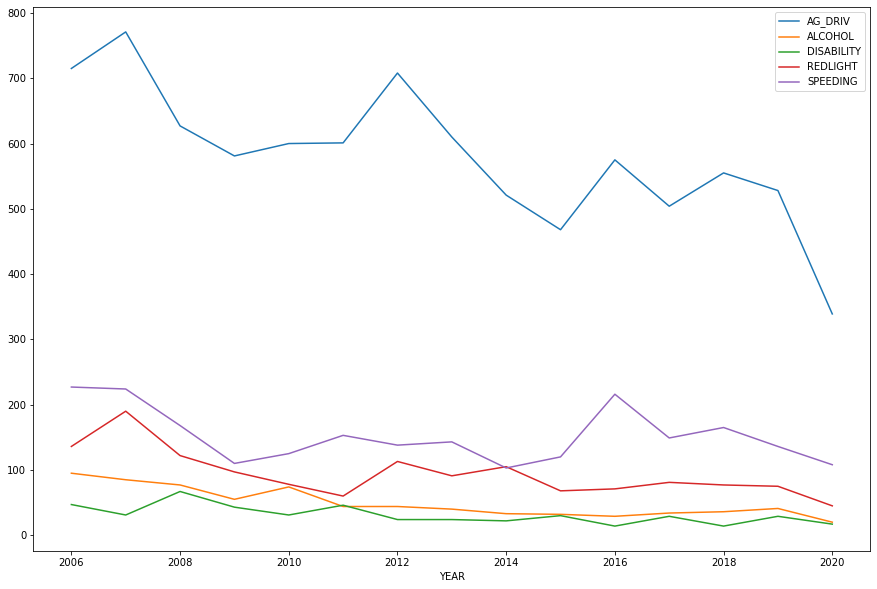

In [85]:
causes.plot(figsize=(15, 10))

Let's see as well how the causes are distributed among the districts.

(                       AG_DRIV  ALCOHOL  DISABILITY  REDLIGHT  SPEEDING
 DISTRICT                                                               
 Etobicoke York            2123      202         128       357       616
 North York                1837      109         109       279       432
 Scarborough               2091      196         102       429       548
 Toronto and East York     2591      223         127       340       668,
 <AxesSubplot:xlabel='DISTRICT'>)

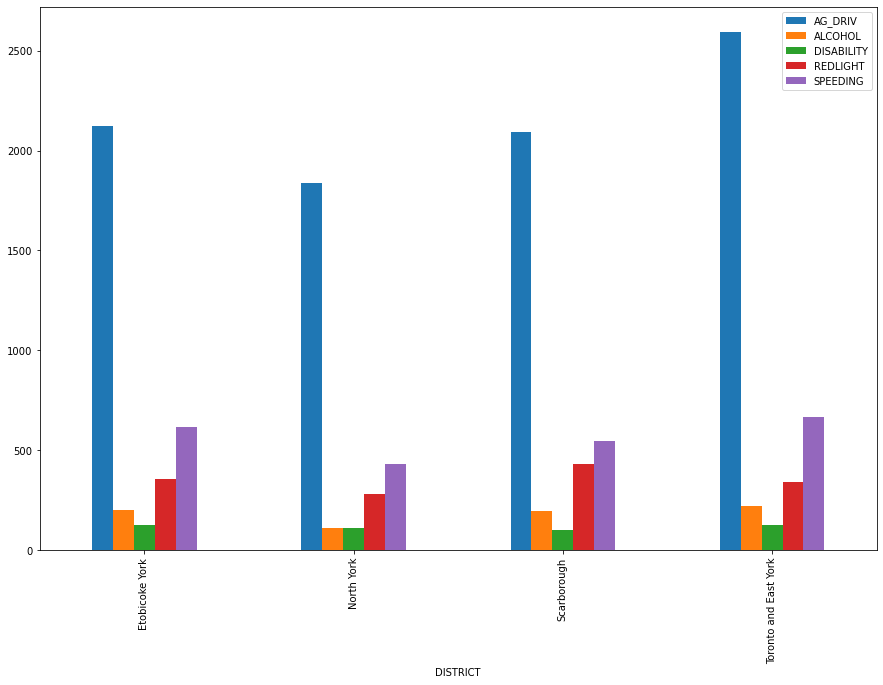

In [86]:
causes_neighborhood = pd.pivot_table(index = 'DISTRICT', data = df_nulls, values = ['ALCOHOL', 'AG_DRIV', 'DISABILITY', 'REDLIGHT', 'SPEEDING'], aggfunc = np.sum)
(causes_neighborhood, causes_neighborhood.plot(figsize=(15, 10), kind = 'bar'))

Aggresive driving is also behind most of the cases that produce major injuries, but is also present in the situations where no injuries are reported. Again, this might have to do with the way they are reported, as a case might leave a party injured and the other not.

(         AG_DRIV  ALCOHOL  DISABILITY  REDLIGHT  SPEEDING
 INJURY                                                   
 Fatal        376       40          18        53       162
 Major       2844      246         162       392       689
 Minimal      689       63          47       187       206
 Minor        824      123          49       217       310
 None        3157      185         134       431       675,
 <AxesSubplot:xlabel='INJURY'>)

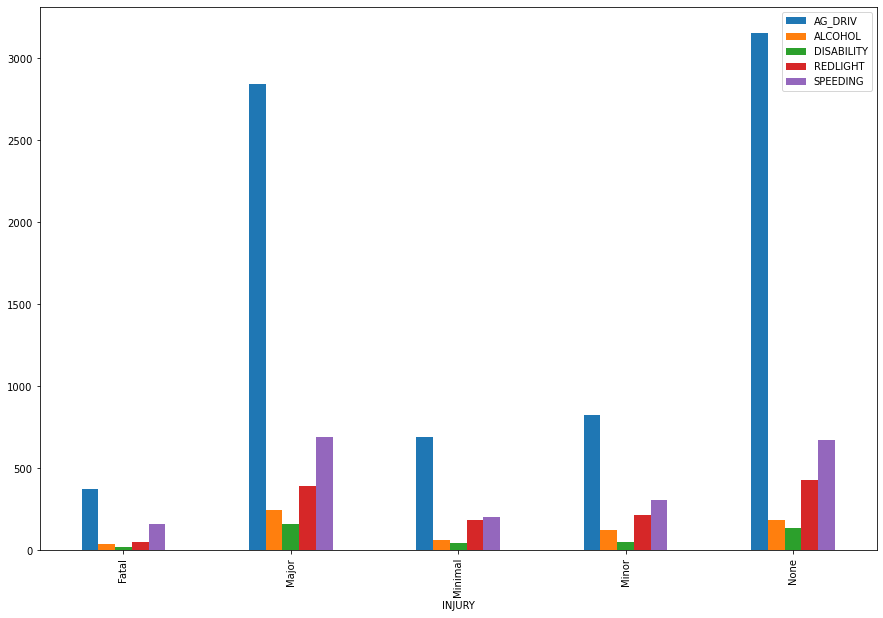

In [87]:
causes_injury = pd.pivot_table(index = 'INJURY', data = df_nulls, values = ['ALCOHOL', 'AG_DRIV', 'DISABILITY', 'REDLIGHT', 'SPEEDING'], aggfunc = np.sum)
(causes_injury, causes_injury.plot(figsize=(15, 10), kind = 'bar'))

# Distribution of Severity of Injuries per Party Involved

The following chart shows the injuries sustained by the parties involved in accidents. Both pedestrians and drivers attract the highest number

In [88]:
injuries = pd.pivot_table(index = 'INJURY', data = df_nulls, values =['AUTOMOBILE','CYCLIST','EMERG_VEH', 'MOTORCYCLE','PASSENGER', 'PEDESTRIAN','TRSN_CITY_VEH','TRUCK'], aggfunc = np.sum)
injuries

,AUTOMOBILE,CYCLIST,EMERG_VEH,MOTORCYCLE,PASSENGER,PEDESTRIAN,TRSN_CITY_VEH,TRUCK
INJURY,,,,,,,,
Fatal,680,41,0,75,201,466,64,94
Major,5117,718,8,558,1647,2318,271,245
Minimal,1002,36,1,54,764,151,58,42
Minor,1267,18,3,44,1001,198,79,90
None,5858,815,18,553,2260,3130,364,410


<AxesSubplot:xlabel='INJURY'>

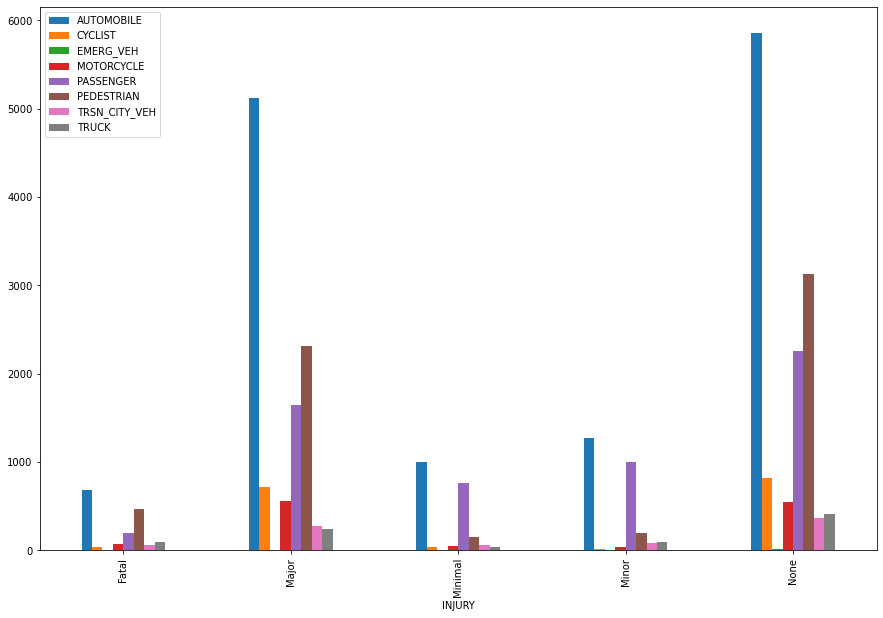

In [89]:
injuries.plot(figsize=(15, 10), kind = 'bar')

## CORRELATION ANALYSIS OF PARTIES INVOLVED IN ACCIDENTS AND CAUSES

In [90]:
#ad-hoc dataframes to explore correlation between parties involved and causes of accidents
#copies of the df with that selected columns are created to extract information of interest
df1 = df_nulls[['AUTOMOBILE','CYCLIST','EMERG_VEH', 'MOTORCYCLE','PASSENGER', 'PEDESTRIAN','TRSN_CITY_VEH']].copy()
df2 = df_nulls[['ALCOHOL', 'AG_DRIV', 'DISABILITY', 'REDLIGHT', 'SPEEDING']].copy()

The parties involved do not seem to present high correlations between each other. The results below are neither highly nor lowly correlated all across the board, so none of these should be inducing multicollinearity.

<AxesSubplot:>

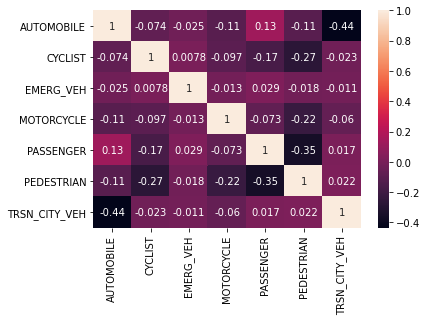

In [91]:
sns.heatmap(df1.corr(), annot=True)

The same can be said for the correlation table for accident causes.

<AxesSubplot:>

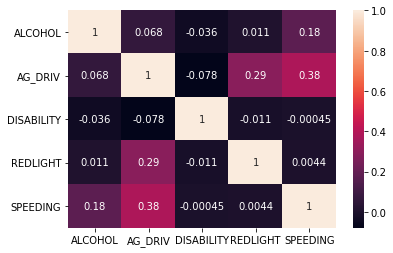

In [92]:
#correlation chart of pivot table
sns.heatmap(df2.corr(), annot=True)

# CLASSIFICATION ANALYSIS

## Classifying Accident Types According to Cause

A logistic regression model is going to be applied so establish a baseline in terms of predicting power for whether fatal and non-fatal accidents can be classified in terms of the cause of collision. Given the dichotomous nature of the target variable (fatality and non-fality of accidents), it has been chosen first this test to try to discrminate the outcome of an accident dependin on the causes, the involved parties and whether road and environmental conditions such as light or visibility are any useful in classificating fatality.

Logistic regression results will be compared against random forest classifier tests. 

In [93]:
#identifying input and target variables 
X = df_nulls[['ALCOHOL', 'AG_DRIV', 'DISABILITY', 'REDLIGHT', 'SPEEDING']]
y = pd.get_dummies(data = df_nulls['ACCLASS'], drop_first = True) 
#0 are fatal cases, whereas 1 are non-fatal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55, stratify = y)

The logistic regression model does not show promising numbers. The recall for fatal cases is somewhat good, proabbly due to the balancing measures set in place when fine-tuning the parameters for the logistic regression, as the data set comes imbalanced.

In [128]:
lr = LogisticRegression(class_weight='balanced', random_state=2400, max_iter=4000)
lr.fit(X_train, np.ravel(y_train))
y_pred = lr.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score: 0.45353894820086993
              precision    recall  f1-score   support

           0       0.16      0.71      0.26       689
           1       0.90      0.41      0.57      4369

    accuracy                           0.45      5058
   macro avg       0.53      0.56      0.41      5058
weighted avg       0.80      0.45      0.53      5058



In [95]:
#crossvalidating results to 10 folds, and producing the mean of said scores
(('Cross-validation scores across 10 folds:',cross_val_score(lr, X_train, np.ravel(y_train), cv=10)),
('Model mean:',np.mean(cross_val_score(lr, X_train, np.ravel(y_train), cv=10))))

(('Cross-validation scores across 10 folds:',
  array([0.46147333, 0.46147333, 0.47457627, 0.46440678, 0.45      ,
         0.46779661, 0.46186441, 0.47627119, 0.45254237, 0.47457627])),
 ('Model mean:', 0.4644980553681884))

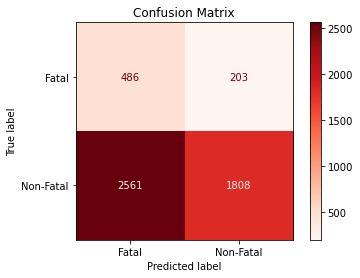

In [96]:
fig = plot_confusion_matrix(lr, X_test, y_test, display_labels=['Fatal', 'Non-Fatal'], cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

A random forest classifier is going to be built to classify the type of accident (fatal and non-fatal) based on the causes listed in the KSI data set (alcohol, aggresive driving, disability, ignoring a red light, or speeding).

In [97]:
#Data is imbalanced, due to the weight of majority class over the minority one (which applies to all the tests ran in this project)
rfc=RandomForestClassifier(n_estimators=70, class_weight = 'balanced', max_features = 4)
#Running the test, and the subsequents with the blanaced condition set up, so that weight of overrepresented condition(non-letahlity) is atenuated
#fitting the model
rfc.fit(X_train, np.ravel(y_train)) 
y_pred_rfc = rfc.predict(X_test)

In [98]:
print("Accuracy Score:",accuracy_score(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfc))

Accuracy Score: 0.45749308026888097
              precision    recall  f1-score   support

           0       0.16      0.70      0.26       689
           1       0.90      0.42      0.57      4369

    accuracy                           0.46      5058
   macro avg       0.53      0.56      0.42      5058
weighted avg       0.80      0.46      0.53      5058



For the conditions labeled as 0 (fatal accidents) and 1 (non-fatal), the test is not recalling that many postive cases, as the improvement is marginal.

In [99]:
#crossvalidating results to 10 folds, and producing the mean of said scores
(('Cross-validation scores across 10 folds:',cross_val_score(rfc, X_train, np.ravel(y_train), cv=10)),
('Model mean:',np.mean(cross_val_score(rfc, X_train, np.ravel(y_train), cv=10))))

(('Cross-validation scores across 10 folds:',
  array([0.46486029, 0.47078747, 0.48305085, 0.47033898, 0.45423729,
         0.47372881, 0.46694915, 0.47881356, 0.45932203, 0.4779661 ])),
 ('Model mean:', 0.46882001750886204))

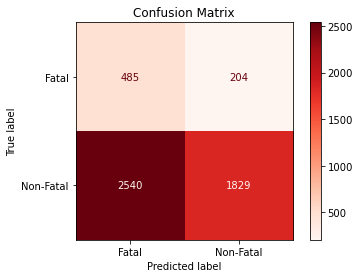

In [100]:
fig = plot_confusion_matrix(rfc, X_test, y_test, display_labels=['Fatal', 'Non-Fatal'], cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

Despite all, it seems logical that both speeding and aggresive driving have a big weight in being the features predicting the model. However, results across the board yield further investigation. Other approaches, like clustering by district, neighborhood or streets could also be of interest to predict fatality and non-fatality. In addition, similar test can be run by selecting new features or isolating those that are promising.

<AxesSubplot:title={'center':'Feature Importance'}>

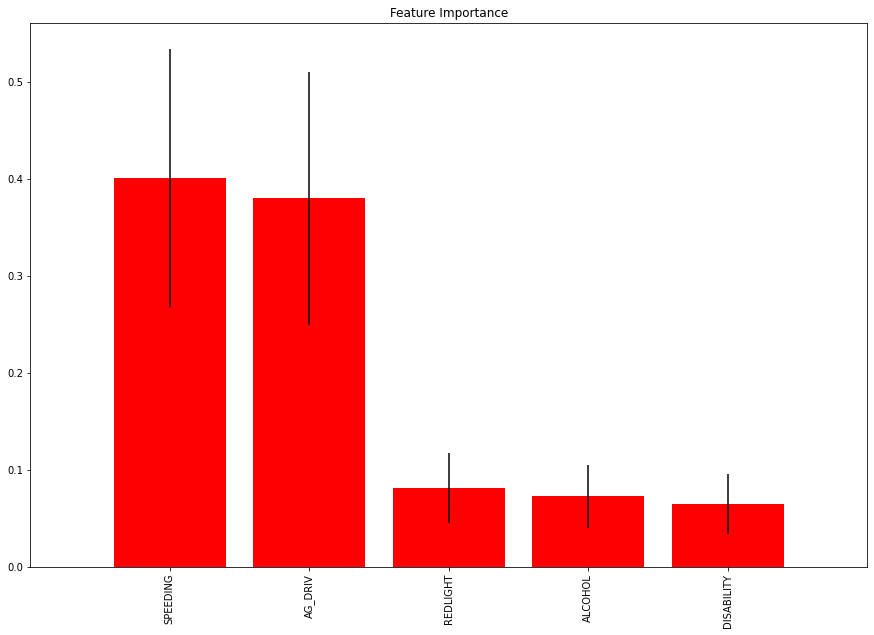

In [101]:
#assessing the feature importance with the results that the rfc has produced
feature_names = X.columns

skplt.estimators.plot_feature_importances(rfc, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90)


## Classifiying Accident Types Based On Actor

A logistic regression model is going to be implemented to first get a baseline of the classification power of this model, that assess the fatality of an accident based on the actor involved in it.

In [102]:
#identifying input and target variables 
X_actor = df_nulls[['AUTOMOBILE','CYCLIST','EMERG_VEH', 'MOTORCYCLE','PASSENGER', 'PEDESTRIAN','TRSN_CITY_VEH']]
y1 = pd.get_dummies(data = df_nulls['ACCLASS'], drop_first = True)
#0 are fatal cases, whereas 1 are non-fatal
X_actor_train, X_actor_test, y1_train, y1_test = train_test_split(X_actor, y1, test_size=0.3, random_state=99, stratify = y)

In [103]:
lr = LogisticRegression(solver='newton-cg', class_weight= 'balanced', random_state=3000, max_iter=2000)
lr.fit(X_actor_train, np.ravel(y1_train))
y1_pred = lr.predict(X_actor_test)
print("Accuracy Score:",accuracy_score(y1_test, y1_pred))

Accuracy Score: 0.5844207196520363


The model is able to recall both conditions, which is kind of promising. 

In [104]:
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       0.18      0.57      0.27       689
           1       0.90      0.59      0.71      4369

    accuracy                           0.58      5058
   macro avg       0.54      0.58      0.49      5058
weighted avg       0.80      0.58      0.65      5058



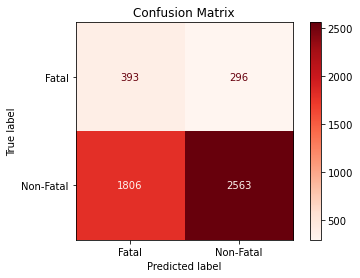

In [105]:
fig = plot_confusion_matrix(lr, X_actor_test, y1_test, display_labels=['Fatal', 'Non-Fatal'], cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

In [106]:
#crossvalidating results to 10 folds, and producing the mean of said scores
(('Cross-validation scores across 10 folds:',cross_val_score(lr, X_actor_train, np.ravel(y1_train), cv=10)),
('Model mean:',np.mean(cross_val_score(lr, X_actor_train, np.ravel(y1_train), cv=10))))

(('Cross-validation scores across 10 folds:',
  array([0.57324301, 0.5876376 , 0.56016949, 0.57711864, 0.57627119,
         0.56864407, 0.5779661 , 0.56779661, 0.60169492, 0.55847458])),
 ('Model mean:', 0.5749016202873176))

In [107]:
rfc1=RandomForestClassifier(n_estimators=1000, class_weight = 'balanced', max_features = 'auto', max_depth = 140)
#fitting the model
rfc1.fit(X_actor_train, np.ravel(y1_train)) 

y1_pred_rfc = rfc1.predict(X_actor_test)
print("Accuracy Score:",accuracy_score(y1_test, y1_pred_rfc))

Accuracy Score: 0.5808620007908264


In [108]:
print(classification_report(y1_test, y1_pred_rfc))


              precision    recall  f1-score   support

           0       0.18      0.60      0.28       689
           1       0.90      0.58      0.70      4369

    accuracy                           0.58      5058
   macro avg       0.54      0.59      0.49      5058
weighted avg       0.80      0.58      0.65      5058



Improvement is also marginal.

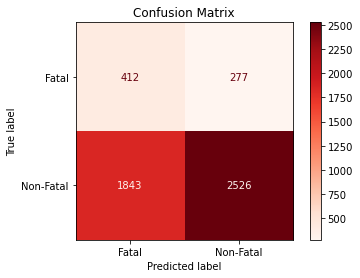

In [109]:
fig = plot_confusion_matrix(rfc1, X_actor_test, y1_test, display_labels=['Fatal', 'Non-Fatal'], cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

In [111]:
(('Cross-validation scores across 10 folds:',cross_val_score(rfc1, X_actor_train, np.ravel(y1_train), cv=10)),
('Model mean:',np.mean(cross_val_score(rfc1, X_actor_train, np.ravel(y1_train), cv=10))))

(('Cross-validation scores across 10 folds:',
  array([0.58509738, 0.60203218, 0.55932203, 0.56610169, 0.58050847,
         0.5940678 , 0.56779661, 0.56779661, 0.58644068, 0.56101695])),
 ('Model mean:', 0.5774417686820994))

As expected, both the presence pedestrians and automobiles (drivers) seem good predictors of the fatality or non-fatality of a traffic accident. 

<AxesSubplot:title={'center':'Feature Importance'}>

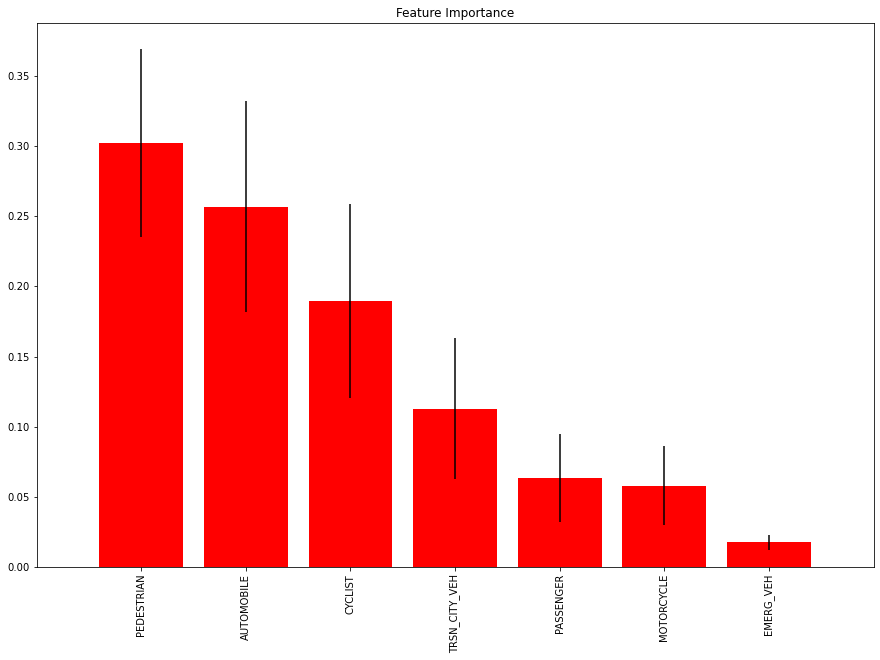

In [112]:
#assessing the feature importance with the results that the rfc has produced
feature_names = X_actor.columns

skplt.estimators.plot_feature_importances(rfc1, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90)


## Light, Visiblity and Road Conditions as Accident Type Classifiers

A logistic regression test and a random forest model is to be implemented to assess whether meteorological and road conditions play some part in the severity of accidents.

In [113]:
#setting up the input and target variables
meteo = pd.get_dummies(data = df_nulls[['LIGHT', 'VISIBILITY', 'RDSFCOND']], drop_first = True)
y2 = pd.get_dummies(data = df_nulls['ACCLASS'], drop_first = True) 
#setting up the train/test splits, on a 75/25 split
meteo_train, meteo_test, y2_train, y2_test = train_test_split (meteo, y2, test_size=0.25, random_state = 5000, stratify= y)

In [114]:
#setting up and running log regression to establish a baseline
lr = LogisticRegression(random_state=3200, max_iter=3000, solver='newton-cg', class_weight='balanced')
lr.fit(meteo_train, np.ravel(y2_train))
y2_pred = lr.predict(meteo_test)

print("Accuracy Score:",accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Accuracy Score: 0.6177935943060499
              precision    recall  f1-score   support

           0       0.16      0.44      0.24       574
           1       0.88      0.65      0.74      3641

    accuracy                           0.62      4215
   macro avg       0.52      0.54      0.49      4215
weighted avg       0.78      0.62      0.68      4215



Road, light and visibility conditions might help to discriminate 

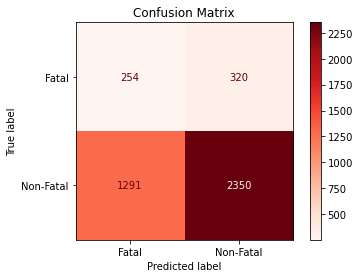

In [115]:
fig = plot_confusion_matrix(lr, meteo_test, y2_test, display_labels=['Fatal', 'Non-Fatal'], cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

In [117]:
(('Cross-validation scores across 10 folds:',cross_val_score(lr, meteo_train, np.ravel(y2_train), cv=10)),
('Model mean:',np.mean(cross_val_score(lr, meteo_train, np.ravel(y2_train), cv=10))))

(('Cross-validation scores across 10 folds:',
  array([0.6229249 , 0.62450593, 0.60316206, 0.62371542, 0.61581028,
         0.60522152, 0.6471519 , 0.6028481 , 0.61471519, 0.60917722])),
 ('Model mean:', 0.6169232501125732))

In [118]:
rfc2=RandomForestClassifier(n_estimators=70, class_weight = 'balanced', max_features= 'auto', max_depth= 340)
#fitting the model
rfc2.fit(meteo_train, np.ravel(y2_train)) 

y2_pred_rfc = rfc2.predict(meteo_test)
print("Accuracy Score:",accuracy_score(y2_test, y2_pred_rfc))

Accuracy Score: 0.631791221826809


In [119]:
print(classification_report(y2_test, y2_pred_rfc))

              precision    recall  f1-score   support

           0       0.17      0.43      0.24       574
           1       0.88      0.66      0.76      3641

    accuracy                           0.63      4215
   macro avg       0.52      0.54      0.50      4215
weighted avg       0.78      0.63      0.69      4215



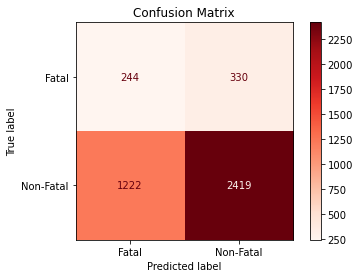

In [120]:
fig = plot_confusion_matrix(rfc2, meteo_test, y2_test, display_labels=['Fatal', 'Non-Fatal'], cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

In [121]:
(('Cross-validation scores across 10 folds:',cross_val_score(rfc2, meteo_train, np.ravel(y2_train), cv=10)),
('Model mean:',np.mean(cross_val_score(rfc2, meteo_train, np.ravel(y2_train), cv=10))))

(('Cross-validation scores across 10 folds:',
  array([0.62529644, 0.61501976, 0.61581028, 0.72094862, 0.61818182,
         0.63528481, 0.65348101, 0.58544304, 0.62658228, 0.61392405])),
 ('Model mean:', 0.6304423500275179))

<AxesSubplot:title={'center':'Feature Importance'}>

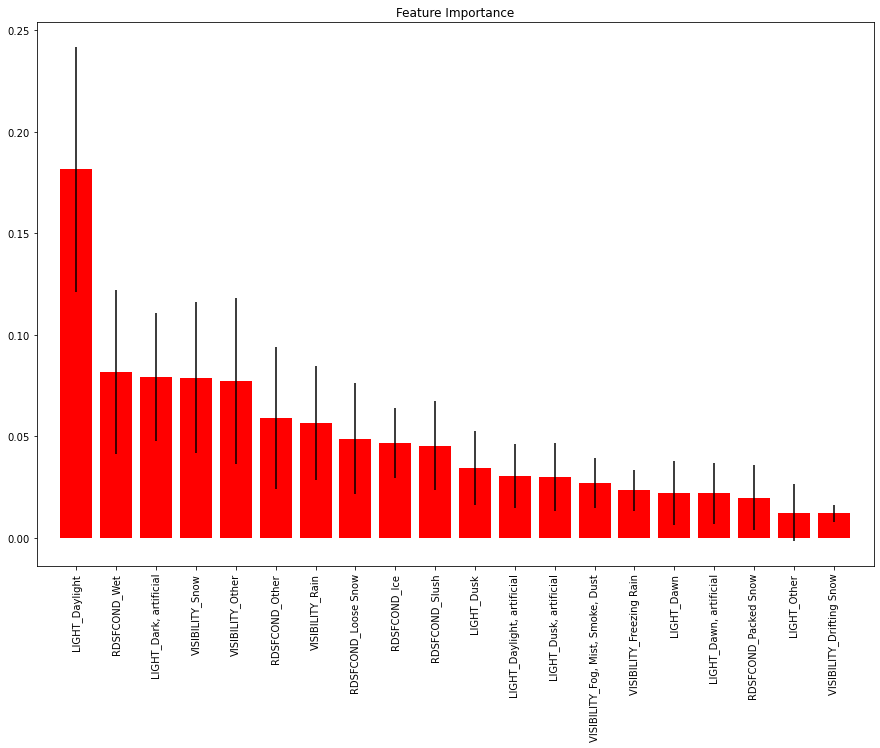

In [122]:
#assessing the feature importance with the results that the rfc has produced
feature_names = meteo.columns

skplt.estimators.plot_feature_importances(rfc2, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90)


All of the models above, despite efforts for controlling umbalances, do not do a great job in discriminating fatal from non-fatal, given the input varaibles provided. But, what if I could isolate both fatal and non-fatal instances and run similar tests?